C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - accuracy: 0.8899 - loss: 0.2760 - val_accuracy: 0.9353 - val_loss: 0.1785
Epoch 2/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9393 - loss: 0.1697 - val_accuracy: 0.9588 - val_loss: 0.1146
Epoch 3/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9623 - loss: 0.1062 - val_accuracy: 0.9752 - val_loss: 0.0715
Epoch 4/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.9748 - loss: 0.0716 - val_accuracy: 0.9796 - val_loss: 0.0576
Epoch 5/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9808 - loss: 0.0565 - val_accuracy: 0.9828 - val_loss: 0.0441
Epoch 6/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9846 - loss: 0.0423 - val_accuracy: 0.9853 - val_loss: 0.0440
Epoch 7/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9869 - loss: 0.0358 - val_accuracy: 0.9885 - val_loss: 0.0375
Epoch 8/20
772/772 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9876 - loss: 0.0340 - 

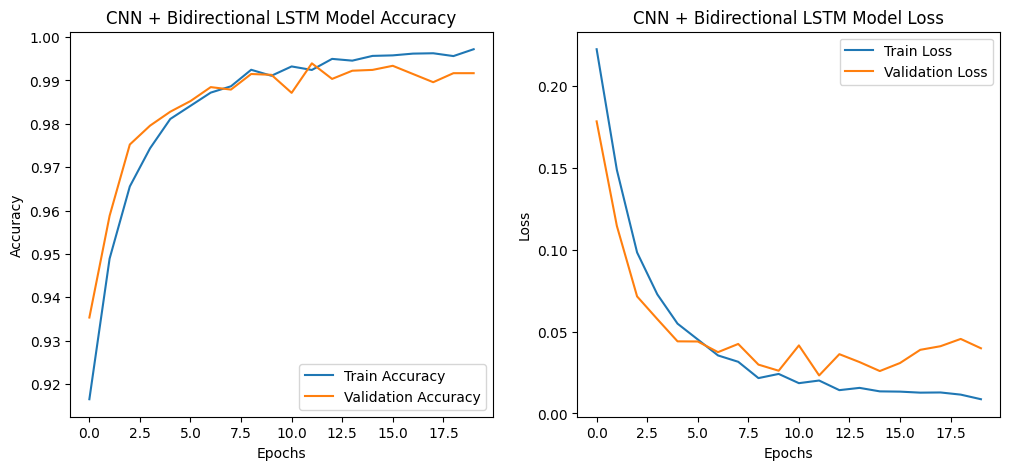

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


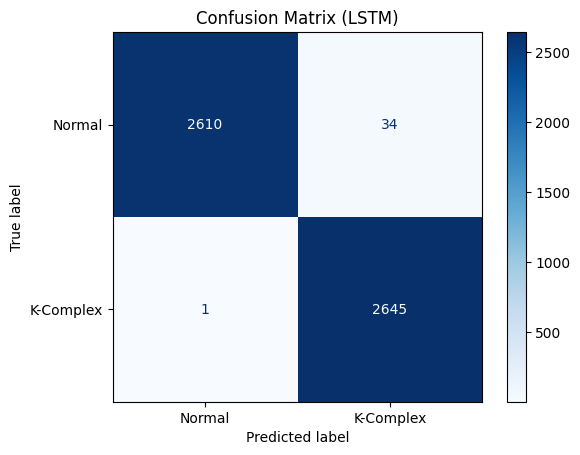

Classification Report (LSTM):
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      2644
   K-Complex       0.99      1.00      0.99      2646

    accuracy                           0.99      5290
   macro avg       0.99      0.99      0.99      5290
weighted avg       0.99      0.99      0.99      5290



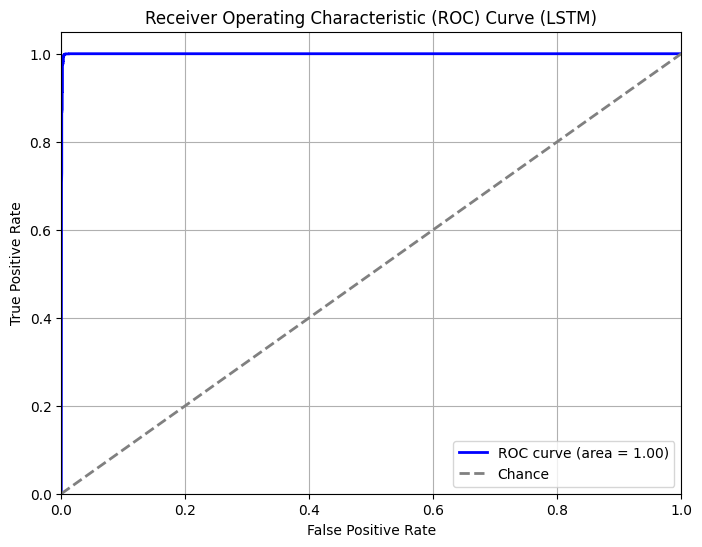

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, LSTM
import os
from tensorflow.keras.utils import to_categorical

folder_path = 'D:/OneDrive_2024-12-27/Segmented by seperating spindles/Balanced_segmented/'

file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.xlsx')]
X_list, y_list = [], []

for file_path in file_paths:
    data = pd.read_excel(file_path)
    X_list.append(data.iloc[:, :-1].values) 
    y_list.append(data.iloc[:, -1].values) 

X = np.vstack(X_list)
y = np.hstack(y_list)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled_reshaped, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)
model_lstm = Sequential()

model_lstm.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(200, 1)))
model_lstm.add(MaxPooling1D(pool_size=2))

model_lstm.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model_lstm.add(MaxPooling1D(pool_size=2))

model_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_lstm.add(Dropout(0.25))

model_lstm.add(Flatten())
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(2, activation='softmax'))

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_lstm = model_lstm.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,  
    batch_size=32,
    verbose=1
)

test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Loss (LSTM): {test_loss_lstm:.4f}")
print(f"Test Accuracy (LSTM): {test_accuracy_lstm:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN + Bidirectional LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('CNN + Bidirectional LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_pred_lstm = model_lstm.predict(X_test)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)

conf_matrix_lstm = confusion_matrix(y_test, y_pred_classes_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lstm, display_labels=['Normal', 'K-Complex'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (LSTM)")
plt.show()

report_lstm = classification_report(y_test, y_pred_classes_lstm, target_names=['Normal', 'K-Complex'])
print("Classification Report (LSTM):")
print(report_lstm)

from sklearn.metrics import roc_curve, auc

fpr_lstm, tpr_lstm, _ = roc_curve(y_test_cat[:, 1], y_pred_lstm[:, 1]) 
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (LSTM)')
plt.legend(loc='lower right')
plt.grid()
plt.show()
